<a href="https://colab.research.google.com/github/karthiknadar1204/generative_deep_learning/blob/main/Lora_Finetuning_project_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#@title <font size="5" color="orange"> Upload images and start training </font>
#@markdown Beginners: Use a different `Project_folder` each time when you upload the images.
import os
from google.colab import drive
drive.mount('/content/drive')

Project_folder = 'AI_PICS/training/AndyLau/testing/7.0' #@param {type:"string"}
pretained_model_name = 'runwayml/stable-diffusion-v1-5' #@param {type:"string"}
Image_repeats = 100 #@param {type:"integer"}
Number_of_epoches = 1 #@param {type:"integer"}
Learning_rate = 0.0001 #@param {type:"number"}
Lora_name = 'AndyLau001' #@param {type:"string"}
Lora_output_path = 'AI_PICS/Lora' #@param {type:"string"}
Skip_image_upload = False #@param {type:"boolean"}
#@markdown Image repeats has no effect if you skip image upload.

# construct paths
projectPath = '/content/drive/MyDrive/' + Project_folder
imagePath = projectPath + '/' + str(Image_repeats) + '_'+ Lora_name
loraPath = '/content/drive/MyDrive/' + Lora_output_path

!mkdir -p {loraPath}


def install():
  !pip list | grep bitsandbytes > /content/bitsandbytespip.txt
  with open('/content/bitsandbytespip.txt', 'r') as file:
      if 'bitsandbytes' in file.read():
        print('Already installed.')
        %cd /content/kohya_ss/
        return

  print('Installing...')

  # Install requirements
  !pip install dadaptation==3.1 diffusers[torch]==0.24.0 easygui==0.98.3 einops==0.6.0 fairscale==0.4.13 ftfy==6.1.1 gradio==3.36.1 huggingface-hub==0.19.4
  !pip install lion-pytorch==0.0.6 lycoris_lora==1.8.0.dev6 open-clip-torch==2.20.0 prodigyopt==1.0 pytorch-lightning==1.9.0 safetensors==0.3.1 timm==0.6.12
  !pip install tk==0.1.0 transformers==4.30.2 voluptuous==0.13.1 wandb==0.15.0 xformers==0.0.20 omegaconf


  # Install bitsandbytes
  !git clone -b 0.41.0 https://github.com/TimDettmers/bitsandbytes
  %cd /content/bitsandbytes
  !CUDA_VERSION=118 make cuda11x
  !python setup.py install

  # Install kohya
  %cd /content
  !git clone https://github.com/bmaltais/kohya_ss.git
  %cd kohya_ss/
  !git checkout v21.8.9

  # update torchvision to a compatible version
  !pip install torch==2.0.1+cu117 torchvision -f https://download.pytorch.org/whl/torch_stable.html

  # add pwd to python path or else blip captioning won't work
  %env PYTHONPATH=/env/python:/content/kohya_ss


if not Skip_image_upload:
  # Manually add image paths and captions
  image_paths_and_captions = [
      ("/content/drive/MyDrive/AI_PICS/training/AndyLau/testing/7.0/Thank_you_image_2.jpeg", "A female person performing the thank you sign using one hand placed at the side of her mouth."),
      ("/content/drive/MyDrive/AI_PICS/training/AndyLau/testing/7.0/Thank_you_4.jpeg", "A male child person performing the thank you sign using one hands placed at the side of his mouth."),
      ("/content/drive/MyDrive/AI_PICS/training/AndyLau/testing/7.0/Thank_you_3.jpeg", "A female person performing the thank you sign using one hand placed at the side of her mouth."),
      ("/content/drive/MyDrive/AI_PICS/training/AndyLau/testing/7.0/Thank_you_1.jpeg", "A female person performing the thank you sign using one hand placed at the side of her mouth."),
      ("/content/drive/MyDrive/AI_PICS/training/AndyLau/testing/7.0/Screenshot 2024-06-05 at 9.17.47 PM.png", "A male person performing the thank you sign by placing both hands by the side of the mouth")
  ]

  import shutil

  # Create the destination directory if it doesn't exist
  if not os.path.exists(imagePath):
      os.makedirs(imagePath)

  # Copy images and create caption files
  for img_path, caption in image_paths_and_captions:
      img_filename = os.path.basename(img_path)
      dst_path = os.path.join(imagePath, img_filename)
      shutil.copyfile(img_path, dst_path)

      # Create a caption text file
      caption_filename = os.path.splitext(img_filename)[0] + ".txt"
      caption_path = os.path.join(imagePath, caption_filename)
      with open(caption_path, 'w') as f:
          f.write(caption)

  print('Images and captions added successfully.\n')


install()

# Skip auto-captioning

# Run training
!accelerate launch --num_cpu_threads_per_process=2 "./train_network.py"     \
                         --enable_bucket --min_bucket_reso=256 --max_bucket_reso=2048               \
                         --pretrained_model_name_or_path={pretained_model_name}           \
                         --train_data_dir={projectPath}         \
                         --resolution="512,650" --output_dir={loraPath}  \
                         --network_alpha="64" --save_model_as=safetensors                           \
                         --network_module=networks.lora --text_encoder_lr=5e-05 --unet_lr={Learning_rate}    \
                         --network_dim=64 --output_name={Lora_name} --lr_scheduler_num_cycles="1"        \
                         --no_half_vae --learning_rate={Learning_rate} --lr_scheduler="constant"           \
                         --train_batch_size="3" --max_train_steps="100000" --save_every_n_epochs="99999"   \
                         --mixed_precision="fp16" --save_precision="fp16" --seed="1234"             \
                         --caption_extension=".txt" --cache_latents --optimizer_type="AdamW"        \
                         --max_data_loader_n_workers="1" --clip_skip=2 --bucket_reso_steps=64       \
                         --max_train_epochs={Number_of_epoches}\
                         --mem_eff_attn --xformers --bucket_no_upscale --noise_offset=0.05


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Images and captions added successfully.

Installing...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.7/92.7 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 34.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

Cloning into 'bitsandbytes'...
remote: Enumerating objects: 7263, done.
remote: Counting objects: 100% (2630/2630), done.
remote: Compressing objects: 100% (612/612), done.
remote: Total 7263 (delta 2226), reused 2230 (delta 1998), pack-reused 4633
Receiving objects: 100% (7263/7263), 2.22 MiB | 23.24 MiB/s, done.
Resolving deltas: 100% (4905/4905), done.
Note: switching to 'a06a0f6a08cb23754b110359a109e069fa97ce9e'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

/content/bitsandbytes
mkdir -p build
mkdir -p dependencies
ENV

/content


  0%|          | 0/25 [00:00<?, ?it/s]

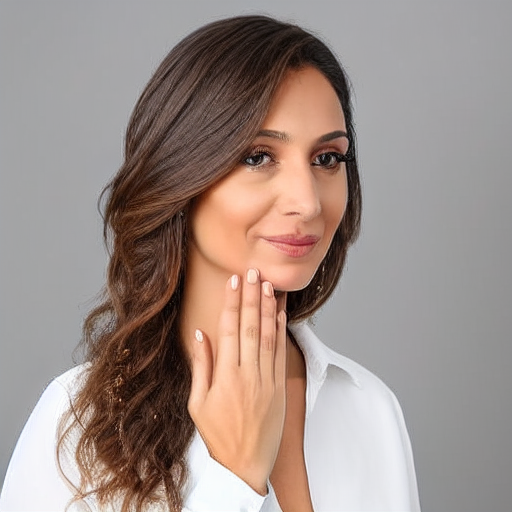

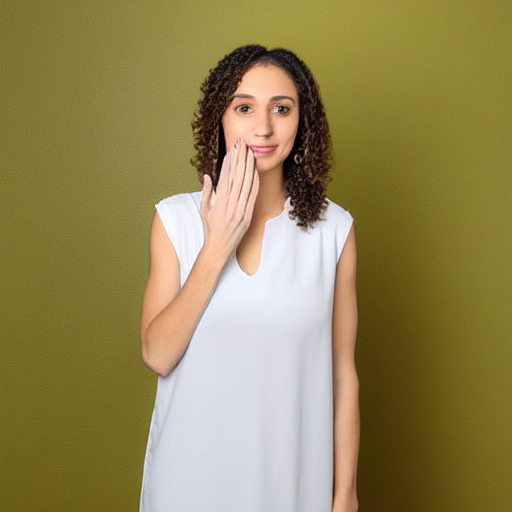

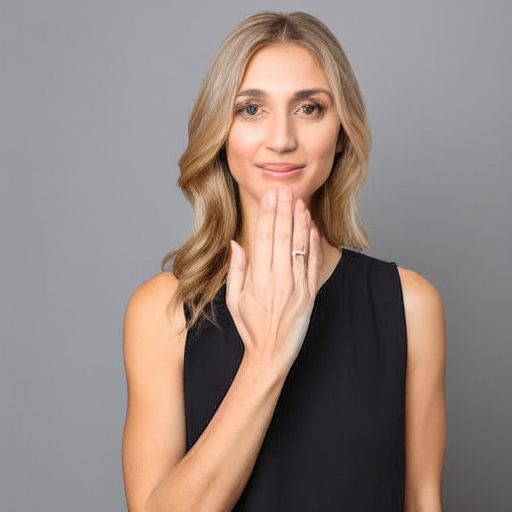

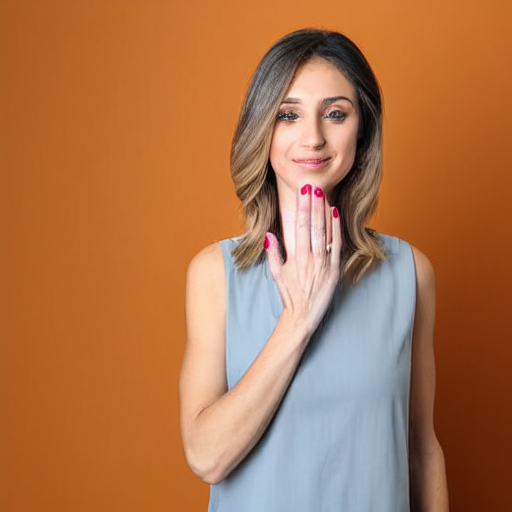

In [6]:
# Parameters for image generation
prompt = "A female person performing the thank you sign using one hand placed at the side of her mouth."  # Update this as needed
negative_prompt = "disfigured, deformed"  #@param {type:"string"}
num_samples = 4  #@param {type:"number"}
guidance_scale = 7.5  #@param {type:"number"}
num_inference_steps = 25  #@param {type:"number"}
height = 512  #@param {type:"number"}
width = 512  #@param {type:"number"}
seed = 100  #@param {type:"number"}

%cd /content/
import torch
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import numpy as np
from torch import autocast
from IPython.display import display
from ipywidgets import widgets, HBox

# Load the model and LoRA weights
if 'pipe' not in locals():
    pipe = StableDiffusionPipeline.from_pretrained(pretained_model_name, safety_checker=None, torch_dtype=torch.float16)
    pipe.load_lora_weights(loraPath + '/' + Lora_name + '.safetensors')
    pipe.to("cuda")
    pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)

# Set the random seed
g_cuda = torch.Generator(device='cuda')
g_cuda.manual_seed(seed)

# Generate images
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

    # Display images
    for im in images:
        display(im)


In [ ]:
#@title <font size="5" color="orange"> Upload images and start training </font>
#@markdown Beginners: Use a different `Project_folder` each time when you upload the images.
from google.colab import drive
import os
drive.mount('/content/drive')

Project_folder = 'AI_PICS/training/AndyLau/testing/3.0' #@param {type:"string"}
pretained_model_name = 'runwayml/stable-diffusion-v1-5' #@param {type:"string"}
Image_repeats = 100 #@param {type:"integer"}
Number_of_epoches = 1 #@param {type:"integer"}
Learning_rate = 0.0001 #@param {type:"number"}
Lora_name = 'AndyLau001' #@param {type:"string"}
Lora_output_path = 'AI_PICS/Lora' #@param {type:"string"}
Skip_image_upload = False #@param {type:"boolean"}
#@markdown Image repeats has no effect if you skip image upload.

# construct paths
projectPath = '/content/drive/MyDrive/' + Project_folder
imagePath = projectPath + '/' + str(Image_repeats) + '_'+ Lora_name
loraPath = '/content/drive/MyDrive/' + Lora_output_path

!mkdir -p {loraPath}


def install():
  !pip list | grep bitsandbytes > /content/bitsandbytespip.txt
  with open('/content/bitsandbytespip.txt', 'r') as file:
      if 'bitsandbytes' in file.read():
        print('Already installed.')
        %cd /content/kohya_ss/
        return

  print('Installing...')

  # Install requirements
  !pip install dadaptation==3.1 diffusers[torch]==0.24.0 easygui==0.98.3 einops==0.6.0 fairscale==0.4.13 ftfy==6.1.1 gradio==3.36.1 huggingface-hub==0.19.4
  !pip install lion-pytorch==0.0.6 lycoris_lora==1.8.0.dev6 open-clip-torch==2.20.0 prodigyopt==1.0 pytorch-lightning==1.9.0 safetensors==0.3.1 timm==0.6.12
  !pip install tk==0.1.0 transformers==4.30.2 voluptuous==0.13.1 wandb==0.15.0 xformers==0.0.20 omegaconf


  # Install bitsandbytes
  !git clone -b 0.41.0 https://github.com/TimDettmers/bitsandbytes
  %cd /content/bitsandbytes
  !CUDA_VERSION=118 make cuda11x
  !python setup.py install

  # Install kohya
  %cd /content
  !git clone https://github.com/bmaltais/kohya_ss.git
  %cd kohya_ss/
  !git checkout v21.8.9

  # update torchvision to a compatible version
  !pip install torch==2.0.1+cu117 torchvision -f https://download.pytorch.org/whl/torch_stable.html

  # add pwd to python path or else blip captioning won't work
  %env PYTHONPATH=/env/python:/content/kohya_ss


if not Skip_image_upload:
  # Manually add image paths and captions
  image_paths_and_captions = [
      # ("/content/drive/MyDrive/AI_PICS/training/AndyLau/testing/3.0/Thank_you_image_2.jpeg", "A female person performing the thank you sign using one hand placed at the side of her mouth."),
      ("/content/drive/MyDrive/AI_PICS/training/AndyLau/testing/3.0/Thank_you_4.jpeg", "A male child person performing the thank you sign using one hands placed at the side of his mouth."),
      ("/content/drive/MyDrive/AI_PICS/training/AndyLau/testing/3.0/Thank_you_3.jpeg", "A female person performing the thank you sign using one hand placed at the side of her mouth."),
      ("/content/drive/MyDrive/AI_PICS/training/AndyLau/testing/3.0/Thank_you_1.jpeg", "A female person performing the thank you sign using one hand placed at the side of her mouth."),
      ("/content/drive/MyDrive/AI_PICS/training/AndyLau/testing/3.0/Thank_you_5.png", "A male person performing the thank you sign by placing both hands by the side of the mouth")
  ]

  import shutil

  # Create the destination directory if it doesn't exist
  if not os.path.exists(imagePath):
      os.makedirs(imagePath)

  # Copy images and create caption files
  for img_path, caption in image_paths_and_captions:
      img_filename = os.path.basename(img_path)
      dst_path = os.path.join(imagePath, img_filename)
      shutil.copyfile(img_path, dst_path)

      # Create a caption text file
      caption_filename = os.path.splitext(img_filename)[0] + ".txt"
      caption_path = os.path.join(imagePath, caption_filename)
      with open(caption_path, 'w') as f:
          f.write(caption)

  print('Images and captions added successfully.\n')


install()

# Skip auto-captioning

# Run training
!accelerate launch --num_cpu_threads_per_process=2 "./train_network.py"     \
                         --enable_bucket --min_bucket_reso=256 --max_bucket_reso=2048               \
                         --pretrained_model_name_or_path={pretained_model_name}           \
                         --train_data_dir={projectPath}         \
                         --resolution="512,650" --output_dir={loraPath}  \
                         --network_alpha="64" --save_model_as=safetensors                           \
                         --network_module=networks.lora --text_encoder_lr=5e-05 --unet_lr={Learning_rate}    \
                         --network_dim=64 --output_name={Lora_name} --lr_scheduler_num_cycles="1"        \
                         --no_half_vae --learning_rate={Learning_rate} --lr_scheduler="constant"           \
                         --train_batch_size="3" --max_train_steps="100000" --save_every_n_epochs="99999"   \
                         --mixed_precision="fp16" --save_precision="fp16" --seed="1234"             \
                         --caption_extension=".txt" --cache_latents --optimizer_type="AdamW"        \
                         --max_data_loader_n_workers="1" --clip_skip=2 --bucket_reso_steps=64       \
                         --max_train_epochs={Number_of_epoches}\
                         --mem_eff_attn --xformers --bucket_no_upscale --noise_offset=0.05
